In [70]:
from PIL import Image, ImageDraw
from glob import glob
import os
import re
import numpy as np
import pandas as pd
from pprint import pprint
from matplotlib import pyplot as plt
import cv2
import time

In [5]:
def get_mask_path(tile_x, tile_y, mask_type):
    path = directory + f"sentinel-2a-tile-{tile_x}x-{tile_y}y/masks/{mask_type}-mask.png"
    return path

In [480]:
directory = '../phase-01/data/'
timeseries = directory+'sentinel-2a-tile-7680x-10240y/timeseries/'

In [481]:
file=[timeseries+i for i in os.listdir(timeseries) if 'TCI' in i][0]

In [482]:
class TILE:
    def __init__(self, filepath):
        img = cv2.imread(filepath)
        self.array = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        self.shape = self.array.shape
        msk_img = cv2.imread(re.findall('^.*sentinel.*?/', file)[0]+'masks/sugarcane-region-mask.png')
        self.mask = cv2.cvtColor(msk_img, cv2.COLOR_BGR2RGB)
    def image(self):
        plt.figure(figsize=(10,10))
        self.image = plt.imshow(self.array)
    def detect_harvested(self):
        setTime = time.time()
        pixels = self.array.copy()
        mask = self.mask
        width, height, _ = pixels.shape
        x = pixels.reshape(512**2, 3)
        x = pd.DataFrame(x, columns=['r','g','b'])
        mask = pd.DataFrame(mask.reshape(512**2, 3), index = x.index)
        mask_idx = mask[~(mask.sum(axis=1)==0)].index
        x.loc[mask_idx, 'r'] = 0
        x.loc[mask_idx, 'g'] = 0
        x.loc[mask_idx, 'b'] = 0
        idx = x[x.g/(x.sum(axis=1)) < 0.335].index.difference(mask_idx)
        x.loc[idx, 'r'] = 255
        x.loc[idx, 'g'] = 0
        x.loc[idx, 'b'] = 0
        x = x.values.reshape(512,512,3)
        self.area = len(idx)
        pixels = np.array([0,0,255]*512**2).reshape(512,512,3)
        return plt.imshow(x)
    def harvested_area(self):
        if 'self.area' not in locals():
            pixels = self.array.copy()
            mask = self.mask
            width, height, _ = pixels.shape
            x = pixels.reshape(512**2, 3)
            x = pd.DataFrame(x, columns=['r','g','b'])
            mask = pd.DataFrame(mask.reshape(512**2, 3), index = x.index)
            mask_idx = mask[~(mask.sum(axis=1)==0)].index
            idx = x[x.g/(x.sum(axis=1)) < 0.335].index
            self.area = len(idx.difference(mask_idx))
        return self.area
#     def detect_harvested2(self):
        

(512, 512, 3)
Wall time: 218 ms


50373

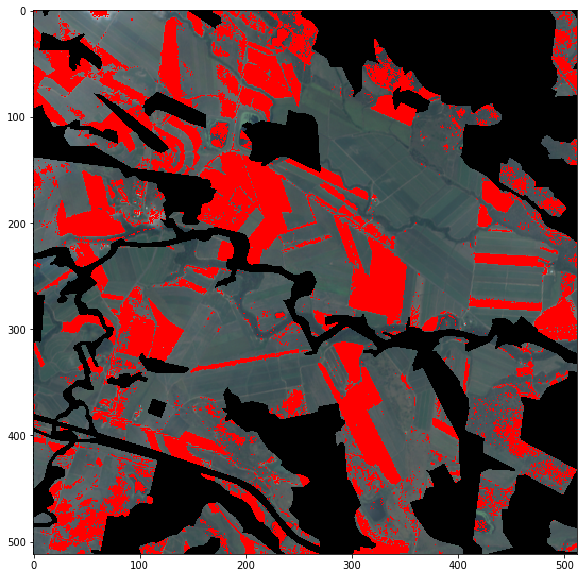

In [483]:
%%time
plt.figure(figsize=(10,10))
img = TILE(file)
print(img.shape)
img.detect_harvested()
img.harvested_area()

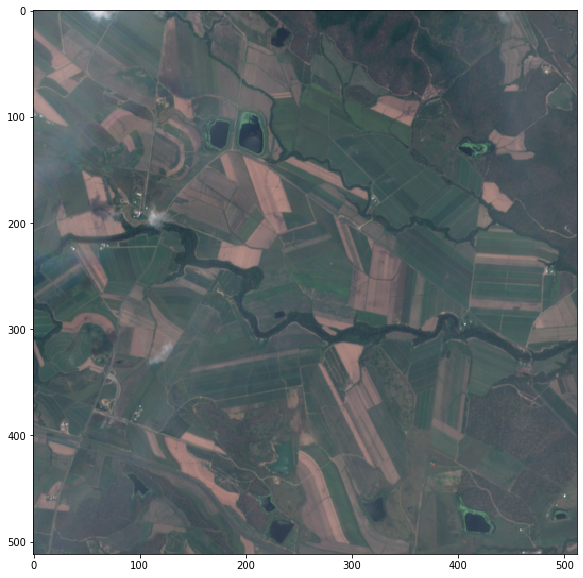

In [484]:
img.image()